In [26]:
%matplotlib notebook

import os
import sys
import numpy as np
import pandas as pd
import time

import torch
import pickle
import qgrid

import matplotlib.pyplot as plt
import IPython.display as ipd

import warnings
warnings.filterwarnings('ignore')

from scipy.io import wavfile
import scipy.fftpack as fftpack

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from python.utils import *

## Load data

In [3]:
data = pd.read_csv('../data/data.csv', index_col=0)

## Parameters

In [34]:
normalize = False 
sample_rate = 44100
sr = sample_rate
frame_sizes = [1024, 2048, 4096]
frame_rate = 100
hop_size = sample_rate/frame_rate
window = [np.hamming(frame_size) for frame_size in frame_sizes]
num_fft_bins = [frame_size >> 1 for frame_size in frame_sizes]

bin_frequencies = []
for i in range(len(frame_sizes)):
    bin_frequencies.append(np.fft.fftfreq(frame_sizes[i], 1. / sample_rate)[:num_fft_bins[i]])

## Functions

In [12]:
# Functions 

def signal_frame(signal, index, frame_size, hop_size, origin=0):
    
    frame_size = int(frame_size)
    num_samples = len(signal)
    ref_sample = int(index * hop_size)
    start = ref_sample - frame_size // 2 - int(origin)
    stop = start + frame_size

    if (stop < 0) or (start > num_samples):
        # window falls completely outside the actual signal, return just zeros
        frame = np.repeat(signal[:1] * 0, frame_size, axis=0)
        return frame
    elif (start < 0) and (stop > num_samples):
        # window surrounds the actual signal, position signal accordingly
        frame = np.repeat(signal[:1] * 0, frame_size, axis=0)
        frame[-start:num_samples - start] = signal
        return frame
    elif start < 0:
        # window crosses left edge of actual signal, pad zeros from left
        frame = np.repeat(signal[:1] * 0, frame_size, axis=0)
        frame[-start:] = signal[:stop, ]
        return frame
    elif stop > num_samples:
        # window crosses right edge of actual signal, pad zeros from right
        frame = np.repeat(signal[:1] * 0, frame_size, axis=0)
        frame[:num_samples - start] = signal[start:, ]
        return frame
    # normal read operation
    return signal[start:stop, ]

def hz2mel(f):
    return 1127.01048 * np.log(np.asarray(f) / 700. + 1.)

def mel2hz(m):
    return 700. * (np.exp(np.asarray(m) / 1127.01048) - 1.)

def mel_frequencies(num_bands, fmin, fmax):
    return mel2hz(np.linspace(hz2mel(fmin), hz2mel(fmax), num_bands))

def frequencies2bins(frequencies, bin_frequencies):
    indices = bin_frequencies.searchsorted(frequencies)
    left = bin_frequencies[indices - 1]
    right = bin_frequencies[indices]
    indices -= frequencies - left < right - frequencies
    return indices

def bins2filterbank(bins, num_fft_bins):
    filterbank = []
    index = 0
    for index in range(len(bins)-2):
        start, center, end = bins[index: index + 3]
        filt = np.zeros(num_fft_bins)
        # rising edge (without the center)
        filt[start:center] = np.linspace(0, 1, center - start, endpoint=False)
        # falling edge (including the center, but without the last bin)
        filt[center:end] = np.linspace(1, 0, end - center, endpoint=False)
        filterbank.append(filt)
    return filterbank

def create_filterbank(bin_frequencies, num_fft_bins, num_bands = 20, fmin = 20., fmax = 17000.):
    frequencies = mel_frequencies(num_bands + 2, fmin, fmax)
    bins = frequencies2bins(frequencies, bin_frequencies)
    filterbank = bins2filterbank(bins, num_fft_bins)
    return np.asarray(filterbank)

def quantize_events(events, fps, length):
    events = np.array(events, dtype=np.float)
    
    events = events[:np.searchsorted(events, float(length - 0.5) / fps)]

    quantized = torch.zeros(length, dtype=torch.long)

    events *= fps
    
    # indices to be set in the quantized array
    idx = np.unique(np.round(events).astype(np.int))
    quantized[idx] = 1

    return quantized

def half_wave_rectifier(arr):
    return (np.abs(arr) + arr) / 2.0

filterbank = []
for i in range(len(frame_sizes)):
    filterbank.append(np.array(create_filterbank(bin_frequencies[i], num_fft_bins[i]), dtype='float32'))

## Calculalte labels

In [ ]:
files = data['file']

start = time.time()
for i, file in enumerate(files):
    signal = get_audio(file)
    annotations = get_annotations(file)
    num_frames = int(np.floor(len(signal) / float(hop_size) + 1))
    
    labels = quantize_events(annotations, fps=frame_rate, length=num_frames)
    pickle.dump(labels, open('../data/labels/' +  '/' +
                                  file + '.npy', 'wb'), protocol=2)
     
end = time.time()
print('\nElapsed time: {:d} min and {:d} s'.format(np.int((end - start)/60), np.int((end - start) % 60)))

## Calculate spectrum (frame size 2048)

In [82]:
sr = 44100
frame_sizes = 2048
frame_rate = 100
hop_size = sample_rate/frame_rate
window = np.hamming(frame_size) 
num_fft_bins = frame_size >> 1 
bin_frequencies = np.fft.fftfreq(frame_sizes, 1. / sample_rate)[:num_fft_bins]
filterbank = np.array(create_filterbank(bin_frequencies, num_fft_bins), dtype='float32')

In [84]:
files = data['file'][data['data_set'] == 1]

start = time.time()
for i, file in enumerate(files):  
    print("Progress file {:d} of {:d}".format(i+1, len(files)), end="\r")
    
    signal = get_audio(file)
    num_frames = int(np.floor(len(signal) / float(hop_size) + 1))
    feature = []
    frames = []    

    # Slice audio into frames
    for index in range(num_frames):
        frames.append(signal_frame(signal, index, frame_size, hop_size))

    # Compute FFT    
    fft = np.empty((num_frames, num_fft_bins), np.complex64)

    for f, frame in enumerate(frames):
        fft_signal = np.multiply(frame, window)
        fft[f] = fftpack.fft(fft_signal, frame_size, axis=0)[:num_fft_bins]

    abs_fft = np.square(np.abs(fft))

    filt_spec = np.log(np.dot(abs_fft, filterbank.T) + 1.0)

    shift_length = np.int(frame_size/100.)

    median = [np.pad(filt_spec,((shift, 0), (0, 0)), mode='constant')
              [:-shift,:] for shift in range(1, shift_length+1)]
    median = np.insert(median, 0, filt_spec, axis=0)
    median = np.median(median, axis=0)

    diff_spec = half_wave_rectifier(filt_spec - median)
    diff_spec[:shift_length,:] = 0

    feature.append(torch.tensor(filt_spec, dtype=torch.float32)) 
    feature.append(torch.tensor(diff_spec, dtype=torch.float32)) 
      
    feature_vec = torch.cat(feature, 1)
    pickle.dump(feature_vec, open('../data/inputs/2048/' + '/' +
                                  file + '.npy', 'wb'), protocol=2)
     
end = time.time()
print('\nElapsed time: {:d} min and {:d} s'.format(np.int((end - start)/60), np.int((end - start) % 60)))

Progress file 698 of 698
Elapsed time: 3 min and 30 s


## Process files

In [ ]:
files = data['file'][data['data_set'] == 1]

start = time.time()
for i, file in enumerate(files):  
    print("Progress file {:d} of {:d}".format(i+1, len(files)), end="\r")
    
    signal = get_audio(file)
    num_frames = int(np.floor(len(signal) / float(hop_size) + 1))
    
    feature = []
    
    for j, frame_size in enumerate(frame_sizes): 
    
        frames = []    

        # Slice audio into frames
        for index in range(num_frames):
            frames.append(signal_frame(signal, index, frame_size, hop_size))

        # Compute FFT    
        fft = np.empty((num_frames, num_fft_bins[j]), np.complex64)

        for f, frame in enumerate(frames):
            fft_signal = np.multiply(frame, window[j])
            fft[f] = fftpack.fft(fft_signal, frame_size, axis=0)[:num_fft_bins[j]]

        abs_fft = np.square(np.abs(fft))

        filt_spec = np.log(np.dot(abs_fft, filterbank[j].T) + 1.0)
        
        shift_length = np.int(frame_size/100.)
        
        median = [np.pad(filt_spec,((shift, 0), (0, 0)), mode='constant')
                  [:-shift,:] for shift in range(1, shift_length+1)]
        median = np.insert(median, 0, filt_spec, axis=0)
        median = np.median(median, axis=0)
        
        diff_spec = half_wave_rectifier(filt_spec - median)
        diff_spec[:shift_length,:] = 0
        
        if normalize:
            filt_spec = filt_spec - np.min(filt_spec)
            filt_spec = filt_spec / np.max(filt_spec)
            diff_spec = diff_spec - np.min(diff_spec)
            diff_spec = diff_spec / np.max(diff_spec)
               
        feature.append(torch.tensor(filt_spec, dtype=torch.float32)) 
        feature.append(torch.tensor(diff_spec, dtype=torch.float32)) 
      
    feature_vec = torch.cat(feature, 1)
    pickle.dump(feature_vec, open('../data/inputs/' + '/' +
                                  file + '.npy', 'wb'), protocol=2)
     
end = time.time()
print('\nElapsed time: {:d} min and {:d} s'.format(np.int((end - start)/60), np.int((end - start) % 60)))

## Chroma vector

In [6]:
play_audio(data.at[25,'file'])

In [31]:
files = [data.at[25,'file']]
annotations = get_annotations(data.at[25,'file'])

In [79]:
frame_size = 2048
n_fft = frame_size
window = np.hamming(frame_size)
num_fft_bins = frame_size >> 1 
bin_frequencies = np.fft.fftfreq(frame_size, 1. / sample_rate)[:num_fft_bins]
filterbank = np.array(create_filterbank(bin_frequencies, num_fft_bins), dtype='float32')

fft_freqs = bin_frequencies

n_chroma = 12

In [66]:
def estimate_tuning(y=None, sr=22050, S=None, n_fft=2048,
                    resolution=0.01, bins_per_octave=12, **kwargs):

    pitch, mag = piptrack(y=y, sr=sr, S=S, n_fft=n_fft, **kwargs)

    # Only count magnitude where frequency is > 0
    pitch_mask = pitch > 0

    if pitch_mask.any():
        threshold = np.median(mag[pitch_mask])
    else:
        threshold = 0.0

    return pitch_tuning(pitch[(mag >= threshold) & pitch_mask],
                        resolution=resolution,
                        bins_per_octave=bins_per_octave)


def pitch_tuning(frequencies, resolution=0.01, bins_per_octave=12):
    frequencies = np.atleast_1d(frequencies)

    # Trim out any DC components
    frequencies = frequencies[frequencies > 0]

    if not np.any(frequencies):
        warnings.warn('Trying to estimate tuning from empty frequency set.')
        return 0.0

    # Compute the residual relative to the number of bins
    residual = np.mod(bins_per_octave * hz_to_octs(frequencies), 1.0)

    # Are we on the wrong side of the semitone?
    # A residual of 0.95 is more likely to be a deviation of -0.05
    # from the next tone up.
    residual[residual >= 0.5] -= 1.0

    bins = np.linspace(-0.5, 0.5, int(np.ceil(1. / resolution)) + 1)

    counts, tuning = np.histogram(residual, bins)

    # return the histogram peak
    return tuning[np.argmax(counts)]


def piptrack(y=None, sr=44100, S=None, n_fft=2048, hop_length=None,
             fmin=150.0, fmax=4000.0, threshold=0.1):
    # Check that we received an audio time series or STFT
    if hop_length is None:
        hop_length = int(n_fft // 4)

    # Make sure we're dealing with magnitudes
    S = np.abs(S)

    # Truncate to feasible region
    fmin = np.maximum(fmin, 0)
    fmax = np.minimum(fmax, float(sr) / 2)

#     fft_freqs = time_frequency.fft_frequencies(sr=sr, n_fft=n_fft)

    # Do the parabolic interpolation everywhere,
    # then figure out where the peaks are
    # then restrict to the feasible range (fmin:fmax)
    avg = 0.5 * (S[2:] - S[:-2])

    shift = 2 * S[1:-1] - S[2:] - S[:-2]

    # Suppress divide-by-zeros.
    # Points where shift == 0 will never be selected by localmax anyway
    shift = avg / (shift + (np.abs(shift) < tiny(shift)))

    # Pad back up to the same shape as S
    avg = np.pad(avg, ([1, 1], [0, 0]), mode='constant')
    shift = np.pad(shift, ([1, 1], [0, 0]), mode='constant')

    dskew = 0.5 * avg * shift

    # Pre-allocate output
    pitches = np.zeros_like(S)
    mags = np.zeros_like(S)

    # Clip to the viable frequency range
    freq_mask = ((fmin <= fft_freqs) & (fft_freqs < fmax)).reshape((-1, 1))

    # Compute the column-wise local max of S after thresholding
    # Find the argmax coordinates
    idx = np.argwhere(freq_mask &
                      localmax(S * (S > (threshold * S.max(axis=0)))))

    # Store pitch and magnitude
    pitches[idx[:, 0], idx[:, 1]] = ((idx[:, 0] + shift[idx[:, 0], idx[:, 1]])
                                     * float(sr) / n_fft)

    mags[idx[:, 0], idx[:, 1]] = (S[idx[:, 0], idx[:, 1]]
                                  + dskew[idx[:, 0], idx[:, 1]])

    return pitches, mags


def chroma(sr, n_fft, n_chroma=12, A440=440.0, ctroct=5.0,
           octwidth=2, norm=2, base_c=True):
    n_chroma = int(n_chroma)
    
    wts = np.zeros((n_chroma, n_fft))

    # Get the FFT bins, not counting the DC component
    frequencies = np.linspace(0, sr, n_fft, endpoint=False)[1:]

    frqbins = n_chroma * hz_to_octs(frequencies, A440)

    # make up a value for the 0 Hz bin = 1.5 octaves below bin 1
    # (so chroma is 50% rotated from bin 1, and bin width is broad)
    frqbins = np.concatenate(([frqbins[0] - 1.5 * n_chroma], frqbins))

    binwidthbins = np.concatenate((np.maximum(frqbins[1:] - frqbins[:-1],
                                              1.0), [1]))

    D = np.subtract.outer(frqbins, np.arange(0, n_chroma, dtype='d')).T

    n_chroma2 = np.round(float(n_chroma) / 2)

    # Project into range -n_chroma/2 .. n_chroma/2
    # add on fixed offset of 10*n_chroma to ensure all values passed to
    # rem are positive
    D = np.remainder(D + n_chroma2 + 10*n_chroma, n_chroma) - n_chroma2

    # Gaussian bumps - 2*D to make them narrower
    wts = np.exp(-0.5 * (2*D / np.tile(binwidthbins, (n_chroma, 1)))**2)

    # normalize each column
    wts = normalize(wts, norm=norm, axis=0)

    # Maybe apply scaling for fft bins
    if octwidth is not None:
        wts *= np.tile(
            np.exp(-0.5 * (((frqbins/n_chroma - ctroct)/octwidth)**2)),
            (n_chroma, 1))

    if base_c:
        wts = np.roll(wts, -3, axis=0)

    # remove aliasing columns, copy to ensure row-contiguity
    return np.ascontiguousarray(wts[:, :int(1 + n_fft/2)])


def normalize(S, norm=np.inf, axis=0, threshold=None, fill=None):
    # Avoid div-by-zero
    if threshold is None:
        threshold = tiny(S)

    elif threshold <= 0:
        raise ParameterError('threshold={} must be strictly '
                             'positive'.format(threshold))

    if fill not in [None, False, True]:
        raise ParameterError('fill={} must be None or boolean'.format(fill))

    if not np.all(np.isfinite(S)):
        raise ParameterError('Input must be finite')

    # All norms only depend on magnitude, let's do that first
    mag = np.abs(S).astype(np.float)

    # For max/min norms, filling with 1 works
    fill_norm = 1

    if norm == np.inf:
        length = np.max(mag, axis=axis, keepdims=True)

    elif norm == -np.inf:
        length = np.min(mag, axis=axis, keepdims=True)

    elif norm == 0:
        if fill is True:
            raise ParameterError('Cannot normalize with norm=0 and fill=True')

        length = np.sum(mag > 0, axis=axis, keepdims=True, dtype=mag.dtype)

    elif np.issubdtype(type(norm), np.number) and norm > 0:
        length = np.sum(mag**norm, axis=axis, keepdims=True)**(1./norm)

        if axis is None:
            fill_norm = mag.size**(-1./norm)
        else:
            fill_norm = mag.shape[axis]**(-1./norm)

    elif norm is None:
        return S

    else:
        raise ParameterError('Unsupported norm: {}'.format(repr(norm)))

    # indices where norm is below the threshold
    small_idx = length < threshold

    Snorm = np.empty_like(S)
    if fill is None:
        # Leave small indices un-normalized
        length[small_idx] = 1.0
        Snorm[:] = S / length

    elif fill:
        # If we have a non-zero fill value, we locate those entries by
        # doing a nan-divide.
        # If S was finite, then length is finite (except for small positions)
        length[small_idx] = np.nan
        Snorm[:] = S / length
        Snorm[np.isnan(Snorm)] = fill_norm
    else:
        # Set small values to zero by doing an inf-divide.
        # This is safe (by IEEE-754) as long as S is finite.
        length[small_idx] = np.inf
        Snorm[:] = S / length

    return Snorm


def tiny(x):
    # Make sure we have an array view
    x = np.asarray(x)

    # Only floating types generate a tiny
    if np.issubdtype(x.dtype, np.floating) or np.issubdtype(x.dtype, np.complexfloating):
        dtype = x.dtype
    else:
        dtype = np.float32

    return np.finfo(dtype).tiny


def localmax(x, axis=0):
    paddings = [(0, 0)] * x.ndim
    paddings[axis] = (1, 1)

    x_pad = np.pad(x, paddings, mode='edge')

    inds1 = [slice(None)] * x.ndim
    inds1[axis] = slice(0, -2)

    inds2 = [slice(None)] * x.ndim
    inds2[axis] = slice(2, x_pad.shape[axis])

    return (x > x_pad[tuple(inds1)]) & (x >= x_pad[tuple(inds2)])


def hz_to_octs(frequencies, A440=440.0):
    return np.log2(np.asanyarray(frequencies) / (float(A440) / 16))

In [73]:
start = time.time()
for i, file in enumerate(files):
    
#     print("Progress file {:d} of {:d}".format(i+1, len(files)), end="\r")
    
    # Load audio
    signal = get_audio(file)
    
    num_frames = int(np.floor(len(signal) / float(hop_size) + 1))
    
    feature = []
    
    frames = []    

    # Slice audio into frames
    for index in range(num_frames):
        frames.append(signal_frame(signal, index, frame_size, hop_size))

    # Compute FFT    
    fft = np.empty((num_frames, num_fft_bins), np.complex64)

    for f, frame in enumerate(frames):
        fft_signal = np.multiply(frame, window)
        fft[f] = fftpack.fft(fft_signal, frame_size, axis=0)[:num_fft_bins]

    abs_fft = np.square(np.abs(fft))
    
    print(abs_fft.shape)
    
    tuning = estimate_tuning(S=abs_fft.T, sr=sr, bins_per_octave=n_chroma)


    A440 = 440.0 * 2.0**(float(tuning) / n_chroma)

    chromafb = chroma(sr, n_fft, A440)

    # Compute raw chroma
    raw_chroma = np.dot(chromafb[:,0:1024], abs_fft.T)

    # Compute normalization factor for each frame
    chroma_vector = normalize(raw_chroma, norm=np.inf, axis=0)
    
    

#     filt_spec = np.log(np.dot(abs_fft, filterbank.T) + 1.0)

#     shift_length = np.int(frame_size/100.)

#     median = [np.pad(filt_spec,((shift, 0), (0, 0)), mode='constant')
#               [:-shift,:] for shift in range(1, shift_length+1)]
#     median = np.insert(median, 0, filt_spec, axis=0)
#     median = np.median(median, axis=0)

#     diff_spec = half_wave_rectifier(filt_spec - median)
#     diff_spec[:shift_length,:] = 0

#     if normalize:
#         filt_spec = filt_spec - np.min(filt_spec)
#         filt_spec = filt_spec / np.max(filt_spec)
#         diff_spec = diff_spec - np.min(diff_spec)
#         diff_spec = diff_spec / np.max(diff_spec)

    feature.append(chroma_vector) 
#     feature.append(torch.tensor(diff_spec, dtype=torch.float32)) 
      
#     pickle.dump(feature_vec, open('../data/inputs/' + '/' +
#                                   file + '.npy', 'wb'), protocol=2)
    
#     labels = quantize_events(annotations, fps=frame_rate, length=num_frames)
#     pickle.dump(labels, open('../data/labels/' +  '/' +
#                                   file + '.npy', 'wb'), protocol=2)
     
end = time.time()
print('\nElapsed time: {:d} min and {:d} s'.format(np.int((end - start)/60), np.int((end - start) % 60)))

(3005, 1024)

Elapsed time: 0 min and 1 s


In [75]:
feature

[array([[0.44780332, 0.75125387, 0.97892343, ..., 0.11657385, 0.17425983,
         0.32140074],
        [0.4598735 , 0.75383384, 0.97976604, ..., 0.11765987, 0.17821931,
         0.32618771],
        [0.4723579 , 0.7578612 , 0.98106844, ..., 0.11896841, 0.18235028,
         0.33111987],
        ...,
        [0.41239409, 0.73500157, 0.97967889, ..., 0.11488946, 0.16391429,
         0.30822227],
        [0.42510554, 0.7424387 , 0.97881271, ..., 0.11522238, 0.16713325,
         0.31242341],
        [0.43695823, 0.74798812, 0.97857889, ..., 0.11573721, 0.1705249 ,
         0.3167859 ]])]

<IPython.core.display.Javascript object>


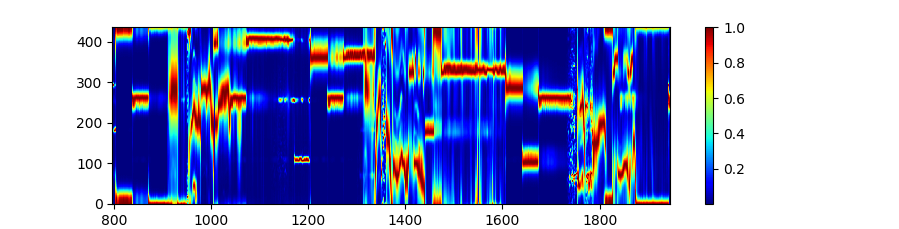

In [78]:
plt.figure(figsize=(9,3))
plt.imshow(chroma_vector, origin='lower', aspect='auto',cmap='jet');
plt.colorbar(format='%.1f')
# for ann in annotations:
#         plt.axvline(x=ann*100, color='w', linestyle=':', linewidth=2);

## Example 

Text(0.5,0,'Time [s]')

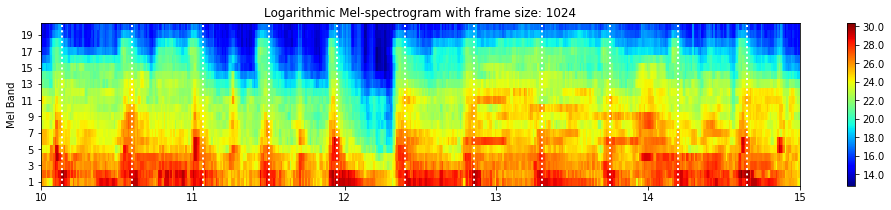

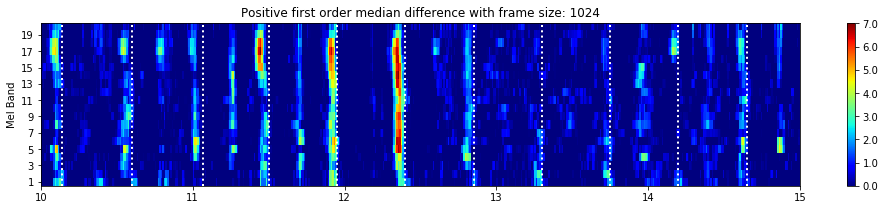

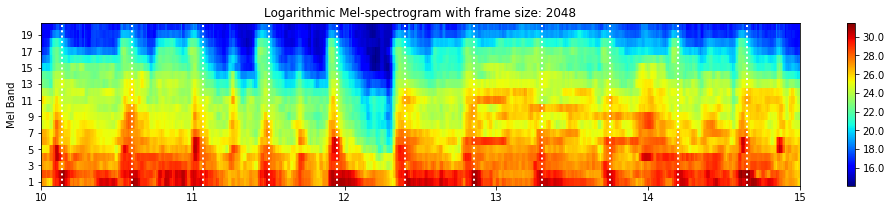

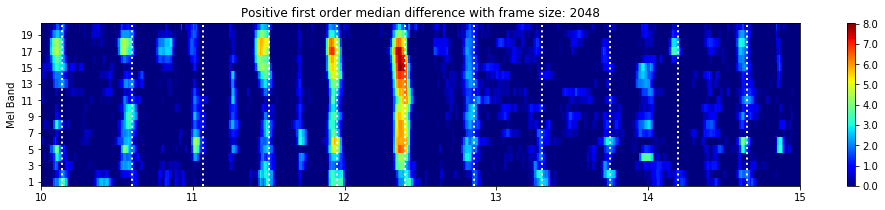

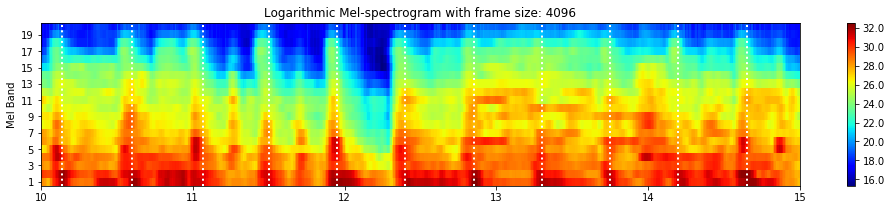

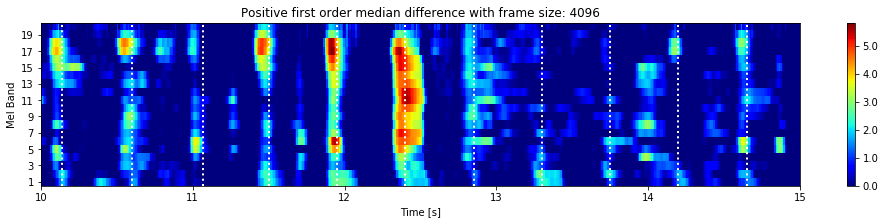

In [30]:
index = 260

input = get_input(data.at[index,'file'])
annotations = get_annotations(data.at[index,'file'])
predictions = get_predictions(data.at[index,'file'])

start = 10
end = 15
num_bands = 20
frame_rate = 100

title = ['Logarithmic Mel-spectrogram with frame size: 1024', 
         'Positive first order median difference with frame size: 1024',
         'Logarithmic Mel-spectrogram with frame size: 2048', 
         'Positive first order median difference with frame size: 2048',
         'Logarithmic Mel-spectrogram with frame size: 4096', 
         'Positive first order median difference with frame size: 4096']

for i in range(6):
    plt.figure(figsize=(17,3))
    plt.title(title[i])

    plt.imshow(np.array(input).T[i*20:(i+1)*20,start*frame_rate:end*frame_rate], 
               extent=(start,end, 0.5, num_bands+0.5),
               origin='lower', aspect='auto',cmap='jet');
    plt.yticks(np.arange(1,20,2));
    plt.ylim(0.5,num_bands+0.5)

    plt.colorbar(format='%.1f');
    
    plt.ylabel('Mel Band');

    for ann in predictions:
        plt.axvline(x=ann, color='w', linestyle=':', linewidth=2)
    plt.xlim(start, end)

plt.xlabel('Time [s]')


Wie sollen die Features normalisiert werden? <br>
Mit Hinblick auf die Eingangsdaten?

## Appendix

In [14]:
# Median Bildung
a = np.random.randn(5,3)
# print('a:\n', a, '\n')

shift_length = 5

median = [np.pad(a,((shift, 0), (0, 0)), mode='edge')[:-shift,:] for shift in range(1, shift_length+1)]
median = np.insert(median, 0, a, axis=0)

# print('median:\n', median)

median = np.median(median, axis=0)

# shift = 1
# np.pad(a,((shift, 0), (0, 0)), mode='edge')[:-1,:]